# EJERCICIO

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,  StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score
import joblib
import warnings

In [18]:
warnings.filterwarnings("ignore", category=FutureWarning)
set_config(display="diagram")

## DEFINICIÓN DEL PROBLEMA

**Vamos a trabajar con un dataframe sobre los datos del titanic que viene en la librería seaborn para intentar predecir si una persona sobrevivió o no a partir del resto de atributos.**

**Como criterio de evaluación vamos a usar la exactitud (accuracy), que mide la proporción de predicciones correctas realizadas por el modelo.**

## RECOPILACIÓN Y PREPARACIÓN DE LOS DATOS

### OBTENER LOS DATOS

In [19]:
df_titanic = sns.load_dataset('titanic')

En el conjunto de datos Titanic, cada columna proporciona información específica sobre los pasajeros del Titanic.

1. `survived`: Esta columna indica si un pasajero sobrevivió o no al naufragio del Titanic. Tiene dos valores posibles: 0 (no sobrevivió) y 1 (sobrevivió).

2. `pclass`: Representa la clase de pasaje del pasajero en el Titanic. Tiene tres valores posibles: 1 (primera clase), 2 (segunda clase) y 3 (tercera clase).

3. `sex`: Indica el género del pasajero, ya sea masculino o femenino.

4. `age`: Representa la edad del pasajero en años.

5. `sibsp`: Indica el número de hermanos o cónyuges que el pasajero tenía a bordo del Titanic.

6. `parch`: Representa el número de padres o hijos que el pasajero tenía a bordo del Titanic.

7. `fare`: Indica la tarifa que el pasajero pagó por su pasaje.

8. `embarked`: Representa el puerto de embarque del pasajero. Tiene tres valores posibles: "C" (Cherbourg), "Q" (Queenstown) y "S" (Southampton).

9. `class`: Similar a `pclass`, pero se expresa en palabras en lugar de números.

10. `who`: Indica si el pasajero es un niño (child), hombre (man) o mujer (woman).

11. `adult_male`: Indica si el pasajero es adulto y masculino.

12. `deck`: Representa la cubierta en la que se encontraba la cabina del pasajero (si es que se encontraba en cubierta).

13. `embark_town`: El nombre de la ciudad o localidad correspondiente al puerto de embarque.

14. `alive`: Indica si el pasajero está vivo o muerto. Similar a `survived`, pero se expresa como "yes" (sí) o "no" (no).

15. `alone`: Indica si el pasajero viajaba solo (True) o con compañía (False).

### EXPLORAR LOS DATOS

Muestra las primeras líneas del dataframe

In [20]:
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


¿Cuántas columnas hay? ¿De que tipo? ¿Cuántos valores no nulos tiene cada columna?

Hay 15 columnas. Abajo utilizo el metodo .info() que te da todos los datos del dataframe, de que tipo es cada columna y cuando valores no nulos tiene cada columna.

In [21]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


Elimina las columnas innecesarias:
- `class`: la información está también en pclass
- `who`: con sex y age se obtiene la información
- `adult_male`: con sex y age se obiene la información
- `deck`: tiene muchos valores nulos y es díficil decidir que valor dar a los valores ausentes
- `embark_town`: la información está también en embarked
- `alive`: la información está también en survived
- `alone`: con sibsp y parch se obtiene la información

In [22]:
df_titatic_dropped=df_titanic.drop(["class","who","adult_male","deck","alive","alone","embark_town"],axis=1)
df_titatic_dropped


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


Muestra las estadísticas básicas de los atributos numéricos

In [23]:
df_titatic_dropped.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Muestra las estadísticas descriptivas de los atributos categóricos (con el parametro include)

In [24]:
df_titatic_dropped.describe(include='object')

,sex,embarked
count,891,889
unique,2,3
top,male,S
freq,577,644


Respresenta los atributos en un histograma o diagrama de barras para ver sus distribuciones: 
- usa seaborn
- dibuja los ochos en un mismo grafico con 8 subgrafos (4x2)
- usa counplot de seaborn para las variables categoricas o discretas
- usa histplot de seaborn para las variables continuas

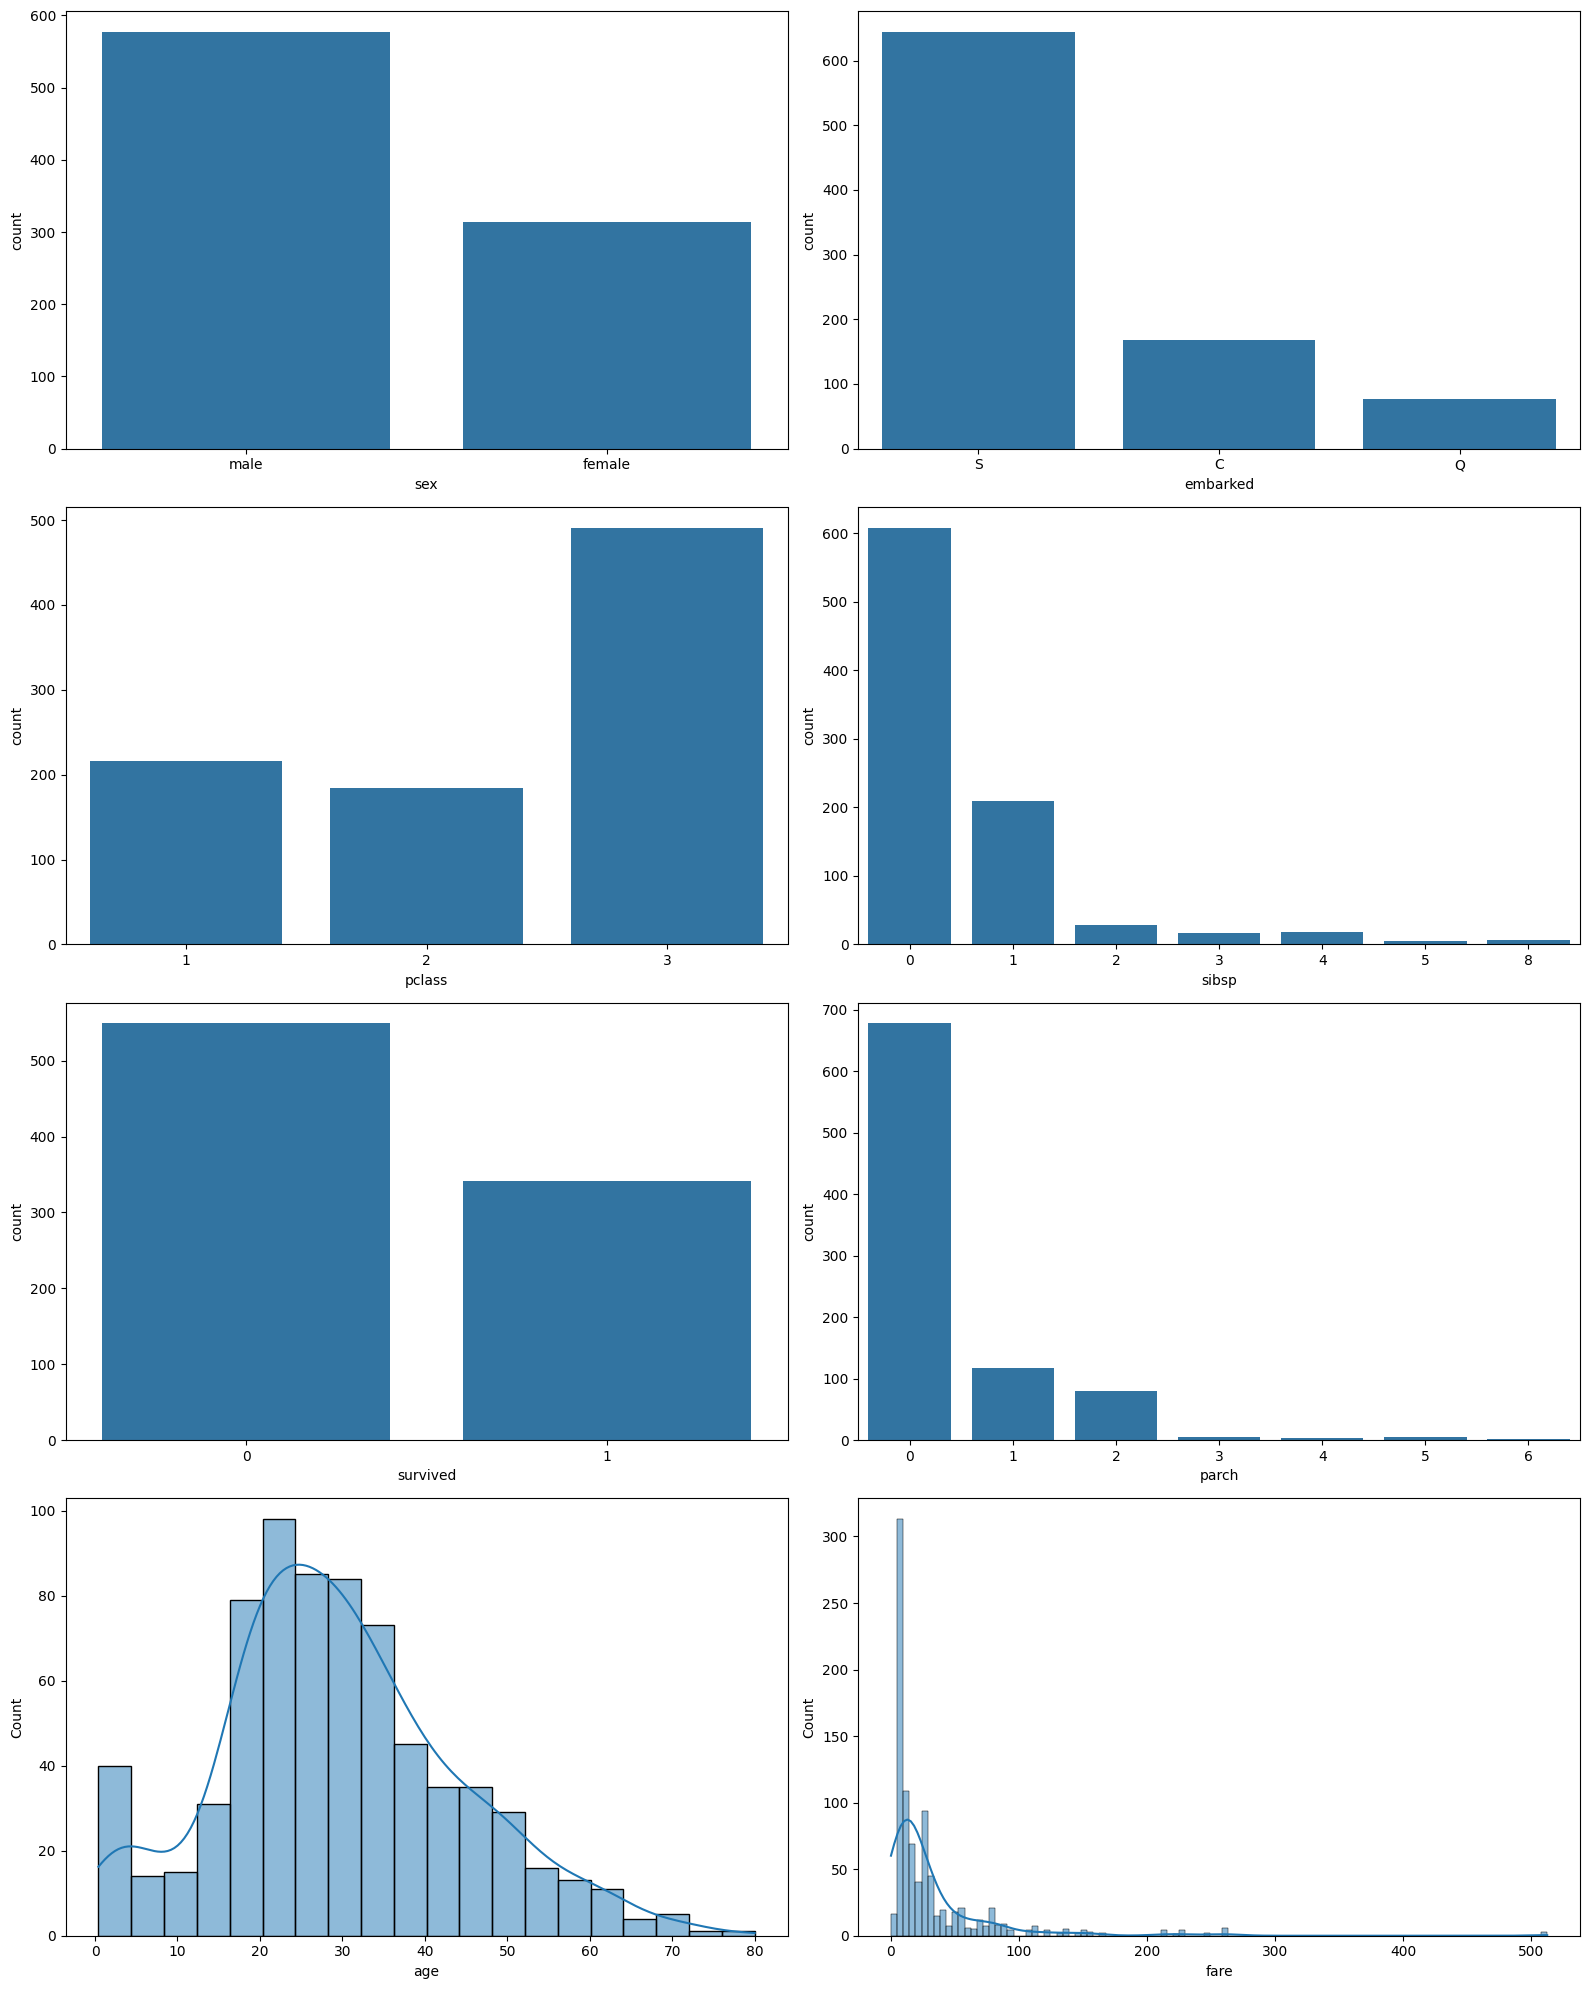

In [25]:
# Definir las variables categóricas y continuas
categorical_vars = ['sex', 'embarked', 'pclass', 'sibsp', 'survived', 'parch']
continuous_vars = ['age', 'fare']

# Crear una figura con 8 subgráficos (4x2)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))  # Figura 4x2

# Graficar las variables categóricas (usando countplot)
for i, var in enumerate(categorical_vars):
    sns.countplot(data=df_titatic_dropped, x=var, ax=axes[i // 2, i % 2])

# Graficar las variables continuas (usando histplot)
for i, var in enumerate(continuous_vars):
    sns.histplot(data=df_titatic_dropped, x=var, ax=axes[(i + len(categorical_vars)) // 2, (i + len(categorical_vars)) % 2], kde=True)

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()
plt.show()

¿A la vista de los datos que conclusiones puedes sacar?

Podemos ver que hay mas hombres que mujeres, que la mayoria de personas tienes entre 20 y 30 años, la mayoria han entrado por el embarque S, hay mucha gente que el precio del crucero ha sido muy bajo, la mayoria de la gente viaja en tercera clase, mucha gente viaja sola y viaja sin hermanos o conyugues y que la mayoria de la gente no sobrevivio.

Muestra la media de supervivientes según el la clase de billete ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [26]:
# Agrupar por clase de billete (pclass) y calcular la media de supervivientes (survived)
df_supervivientes_segun_clase=df_titatic_dropped.groupby('pclass')['survived'].mean().reset_index()

# Ordenar de forma descendente por la media de supervivientes
df_supervivientes_segun_clase = df_supervivientes_segun_clase.sort_values(by='survived', ascending=False)

# Mostrar el DataFrame resultante
print(df_supervivientes_segun_clase)

   pclass  survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


La conclusión que podemos sacar es que sobrevivieron mas personas que viajaban en primera clase que en tercera.

Muestra la media de supervivientes según el sexo ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [27]:
df_supervivientes_segun_sexo=df_titatic_dropped.groupby('sex')["survived"].mean().reset_index()
df_supervivientes_segun_sexo=df_supervivientes_segun_sexo.sort_values(by="survived", ascending=False)
print(df_supervivientes_segun_sexo)

      sex  survived
0  female  0.742038
1    male  0.188908


La conclusión es que sobrevivieron mas mujeres que hombres

Muestra la media de supervivientes según el número de hermanos y coyúnges ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [28]:
df_supervivientes_segun_hermanos=df_titatic_dropped.groupby('sibsp')["survived"].mean().reset_index()
df_supervivientes_segun_hermanos=df_supervivientes_segun_hermanos.sort_values(by="survived", ascending=False)
print(df_supervivientes_segun_hermanos)

   sibsp  survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


La conclusión es que sobrevivieron mas personas que viajaban con un hermano

Muestra la media de supervivientes según el número de padres e hijos ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [29]:
df_supervivientes_segun_padres_hijos=df_titatic_dropped.groupby('parch')["survived"].mean().reset_index()
df_supervivientes_segun_padres_hijos=df_supervivientes_segun_padres_hijos.sort_values(by="survived", ascending=False)
print(df_supervivientes_segun_padres_hijos)

   parch  survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


La conclusión es que sobrevivieron mas personas que viajaban con 3 hijos, luego con 1 y luego con 2

Halla las correlaciones de los datos numéricos y muestra el coeficiente de correlacion de las diferentes variables respecto a la variable survived

In [30]:
corr_matrix = df_titatic_dropped.corr(numeric_only=True)
corr_matrix["survived"].sort_values(ascending=False)

survived    1.000000
fare        0.257307
parch       0.081629
sibsp      -0.035322
age        -0.077221
pclass     -0.338481
Name: survived, dtype: float64

Representa la matriz de correlaciones (representa directamente la matriz usando el stilo background_gradient)

In [31]:
corr_matrix.style.background_gradient()

,survived,pclass,age,sibsp,parch,fare
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


¿Qué conclusiones sacas de la matriz de correlaciones?

- fare y survived tienen una correlación positiva moderada (0.257), lo que sugiere que los pasajeros que pagaron un boleto más caro tienen una mayor probabilidad de sobrevivir. Esto podría estar relacionado con que los boletos de mayor precio estaban en clases más altas.

- pclass y survived tienen una correlación negativa significativa (-0.338). Esto implica que los pasajeros en clases más bajas (pclass más alto) tenían menos probabilidades de sobrevivir. Este es un factor relevante para el modelo, ya que indica que la clase del pasajero influye en la supervivencia.

- age y survived tienen una correlación baja (-0.077). Esto sugiere que la edad tiene poca relación directa con la supervivencia, aunque aún puede aportar información útil en combinación con otras variables.

- sibsp y parch tienen correlaciones positivas moderadas entre sí (0.415), lo cual es lógico porque las personas que viajan con más familiares tienden a tener más acompañantes en ambas categorías.

Vamos a seguir explorando los datos haciendo algún gráfico más:

- Grafico de barras para representar el número de supervivientes según la clase de billete y por sexos

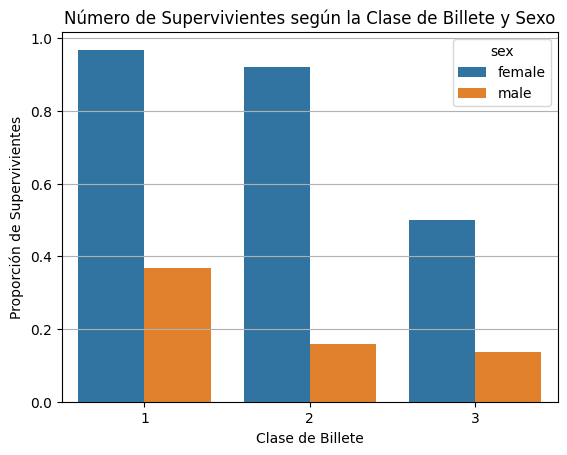

In [32]:
sns.barplot(data=df_titatic_dropped, x="pclass", y="survived", hue="sex", ci=None)

plt.title("Número de Supervivientes según la Clase de Billete y Sexo")
plt.xlabel("Clase de Billete")
plt.ylabel("Proporción de Supervivientes")
plt.grid(axis="y")
plt.show()

- Usando FaceGird de seaborn representa los supervivientes según la clase de billete y el puerto de embarque

/home/iabd24/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


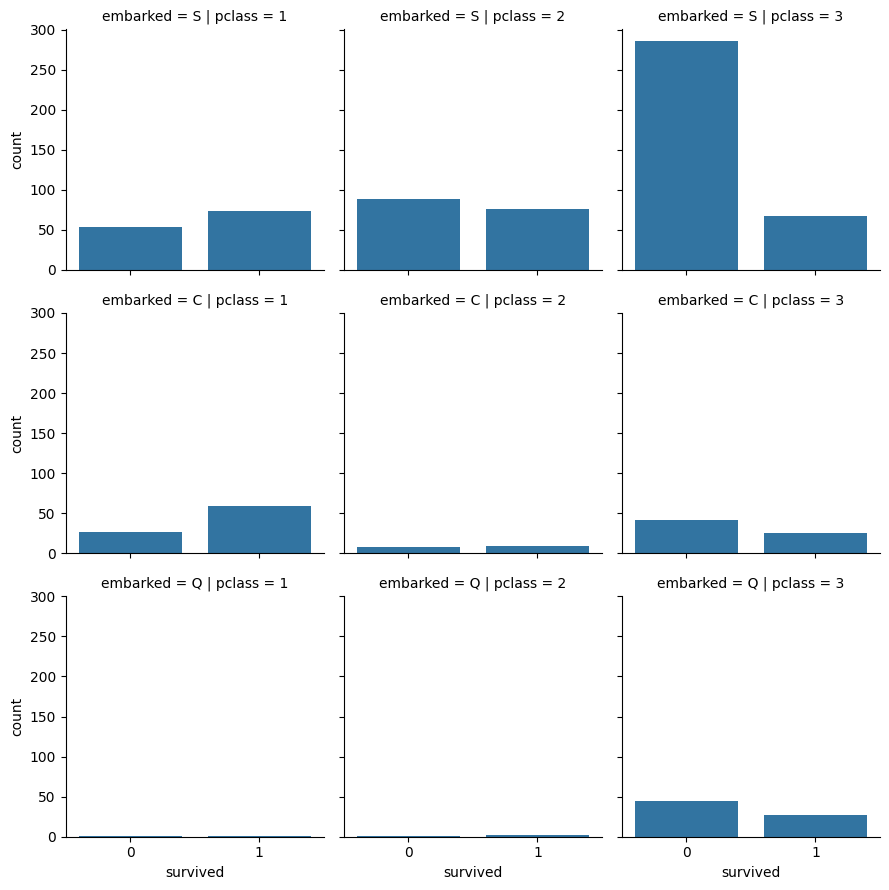

In [33]:
grid=sns.FacetGrid(df_titatic_dropped, col="pclass",row="embarked")
grid.map(sns.countplot,"survived")
plt.show()

### DIVIDIR LOS DATOS

Es hora de separar el conjunto de entrenamiento del conjunto de prueba (85% para el entrenamiento y haciendo un muestreo estratificado según la clase del billete, que parece que es una de las más correlacionada con la carracteristica survived y hay bastante más pasajeros de clase 3 que de clase 1 y2).

In [34]:
strat_train_set, strat_test_set = train_test_split(df_titatic_dropped, test_size=0.15, stratify=df_titatic_dropped["pclass"], random_state=42)
strat_test_set["pclass"].value_counts() / len(strat_test_set)

pclass
3    0.552239
1    0.238806
2    0.208955
Name: count, dtype: float64

Haz una copia del conjunto de entrenamiento para trabajar con él.

In [35]:
train_set_copy = strat_train_set.copy()

### PREPARAR LOS DATOS

Hay que crear un pipeline de transformación que haga los siguientes cambios:
- pclass: 
  - rellenar datos faltantes con la moda
- sex:
  - rellenar datos faltantes con la moda
  - convertir male a 0 y female a 1
- age:
  - rellenar datos faltantes con la media
  - convertirla en variable categórica:
      - 1 - <=16
      - 2 - (16,32]
      - 3 - (32,48]
      - 4 - (48,64]
      - 5 - >64)
- family = sibsp + parch
  - rellenar datos faltantes con la moda
  - sumar las dos columnas
- fare
  - rellenar datos faltantes con la media
  - aplicar raiz cuadrada
  - estandarizar
- embarked
  - rellenar datos faltantes con la moda
  - aplicar one-hot

Pero vamos a empezar poco a poco

Crea el atributo familia como suma de sibsp y parch y luego borra sibsp y parch

In [36]:
train_set_copy['family'] = train_set_copy['sibsp'] + train_set_copy['parch']

train_set_copy.drop(['sibsp', 'parch'], axis=1, inplace=True)

print(train_set_copy.head())

     survived  pclass     sex   age   fare embarked  family
63          0       3    male   4.0  27.90        S       5
465         0       3    male  38.0   7.05        S       0
320         0       3    male  22.0   7.25        S       0
56          1       2  female  21.0  10.50        S       0
348         1       3    male   3.0  15.90        S       2


Rellenamos los datos ausentes en el dataframe (lo hacemos para todas las columnas aunque ahora la mayoría no tiene datos ausentes, pero no sabemos como serán los datos si tenemos que volver a entrenar el modelo)

In [37]:
imputer = ColumnTransformer(transformers=[
    ('pclass', SimpleImputer(strategy='mean'), ['pclass']),
    ('sex', SimpleImputer(strategy='most_frequent'), ['sex']),
    ('age', SimpleImputer(strategy='mean'), ['age']),
    ('family', SimpleImputer(strategy='most_frequent'), ['family']),
    ('fare', SimpleImputer(strategy='mean'), ['fare']),
    ('embarked', SimpleImputer(strategy='most_frequent'), ['embarked'])
], remainder='passthrough')

# Aplicar el imputer y redondear las columnas necesarias
train_set_imputed = imputer.fit_transform(train_set_copy)

# Convertir el resultado a DataFrame y redondear 'age' y 'fare'
train_set_copy_imputed = pd.DataFrame(train_set_imputed, columns=train_set_copy.columns)
train_set_copy_imputed['age'] = train_set_copy_imputed['age'].round(1)

train_set_copy_imputed

,survived,pclass,sex,age,fare,embarked,family
0,3.0,male,4.0,5,27.9,S,0
1,3.0,male,38.0,0,7.05,S,0
2,3.0,male,22.0,0,7.25,S,0
3,2.0,female,21.0,0,10.5,S,1
4,3.0,male,3.0,2,15.9,S,1
...,...,...,...,...,...,...,...
752,3.0,female,5.0,3,19.2583,C,1
753,1.0,male,46.0,0,79.2,C,0
754,3.0,female,29.568966,4,25.4667,S,0
755,1.0,male,61.0,0,32.3208,S,0


En el columna sex sustituir male por 0 y female por 1

In [38]:
train_set_copy['sex'] = train_set_copy['sex'].replace({'male': 0, 'female': 1})

Aplicar One-Hot a la columna embarked

In [39]:
# Crear una instancia del codificador OneHotEncoder
embarked_encoder = OneHotEncoder()

# Ajustar y transformar la columna 'embarked' (usar doble corchete)
embarked_1hot = embarked_encoder.fit_transform(train_set_copy[['embarked']])

# Convertir el resultado a un DataFrame
embarked_1hot_df = pd.DataFrame(embarked_1hot.toarray(), columns=embarked_encoder.get_feature_names_out(['embarked']))

# Unir las columnas dummies al DataFrame original
train_set_copy = pd.concat([train_set_copy, embarked_1hot_df], axis=1)

# Eliminar la columna original 'embarked'
train_set_copy.drop('embarked', axis=1, inplace=True)

print(train_set_copy.head())

     survived  pclass  sex   age   fare  family  embarked_C  embarked_Q  \
63        0.0     3.0  0.0   4.0  27.90     5.0         0.0         0.0   
465       0.0     3.0  0.0  38.0   7.05     0.0         0.0         0.0   
320       0.0     3.0  0.0  22.0   7.25     0.0         0.0         1.0   
56        1.0     2.0  1.0  21.0  10.50     0.0         0.0         0.0   
348       1.0     3.0  0.0   3.0  15.90     2.0         0.0         0.0   

     embarked_S  embarked_nan  
63          1.0           0.0  
465         1.0           0.0  
320         0.0           0.0  
56          1.0           0.0  
348         1.0           0.0  


Convertir la variable age en una variable categórica: 
- 1 - <=16
- 2 - (16,32]
- 3 - (32,48]
- 4 - (48,64]
- 5 - >64)

In [40]:
# Definir los límites de los bins y las etiquetas
bins = [-1, 16, 32, 48, 64, 100]  # Usamos 100 como límite superior
labels = [1,2,3,4,5]

# Convertir 'age' a categórica
train_set_copy['age'] = pd.cut(train_set_copy['age'], bins=bins, labels=labels, right=True)

# Convertir la columna 'age' a tipo category
train_set_copy['age'] = train_set_copy['age'].astype('category')

print(train_set_copy[['age']].head())

    age
63    1
465   3
320   2
56    2
348   1


Como la columna fare tiene una cola larga por la derecha y tiene valores que son cero aplica la raiz cuadrada a la variable

In [41]:
# Aplicar la raíz cuadrada a la columna 'fare', asegurando que los valores negativos no se incluyan
train_set_copy['fare'] = np.sqrt(train_set_copy['fare'])

# Mostrar los resultados para verificar
print(train_set_copy[['fare']].head())

         fare
63   5.282045
465  2.655184
320  2.692582
56   3.240370
348  3.987480


Estandarizar la variable fare

In [42]:
# Crear una instancia del escalador
scaler = StandardScaler()

# Estandarizar la columna 'fare' y reemplazarla en el DataFrame
train_set_copy['fare'] = scaler.fit_transform(train_set_copy[['fare']])

# Mostrar los resultados para verificar
print(train_set_copy[['fare']].head())

         fare
63   0.151298
465 -0.734305
320 -0.721696
56  -0.537019
348 -0.285143


Ya esta el dataframe con los datos de entrenamiento preparados, pero los cambios hechos también hay que hacerlos en los datps de prueba a y en un futuro en otros dataframe bien para entrenar de nuevo el modelo, bien para predecir datos. Por lo tanto, hay que crear una pipeline a la que le pasamos el dataframe y haga todos los cambios.

In [43]:
def column_family(X):
    return X[:, [0]] + X[:, [1]]

def family_name(function_transformer, feature_names_in):
    return ["family"]  # feature names out

def encode_sex(X):
    X[:, 0] = np.where(X[:, 0] == 'male', 0, 1)  # Reemplaza 'male' por 0 y 'female' por 1
    return X

def categorize_age(X):
    bins = [-1, 16, 32, 48, 64, 100]
    labels = [1, 2, 3, 4, 5]
    # Aplicar pd.cut directamente sobre la columna de edad
    categorized_age = pd.cut(X[:, 0], bins=bins, labels=labels).astype(int)
    
    return categorized_age.reshape(-1, 1)

#mode_attibutes=['pclass','sex','embarked']
#mean_attributes=['age','fare']

family_pipeline=make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        FunctionTransformer(column_family, feature_names_out=family_name))

pclass_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"))

sex_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FunctionTransformer(encode_sex, feature_names_out="one-to-one"))

age_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"), 
    FunctionTransformer(categorize_age, feature_names_out="one-to-one")  
)

fare_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    FunctionTransformer(np.sqrt,feature_names_out="one-to-one"),
    StandardScaler())

embarked_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder()
    )

preprocessing = ColumnTransformer([
        ("family",family_pipeline,["parch","sibsp"]),
        ("pclass_transform", pclass_pipeline, ["pclass"]),
        ("sex_transform", sex_pipeline, ["sex"]),
        ("age_transform", age_pipeline, ["age"]),
        ("fare_transform", fare_pipeline, ["fare"]),
        ("embarked_transform", embarked_pipeline, ["embarked"])
    ],verbose_feature_names_out = False)

In [44]:
titanic_prepared = preprocessing.fit_transform(strat_test_set)
preprocessing.get_feature_names_out()

array(['family', 'pclass', 'sex', 'age', 'fare', 'embarked_C',
       'embarked_Q', 'embarked_S'], dtype=object)

In [45]:
titanic_prepared_fr = pd.DataFrame(
    titanic_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=strat_test_set.index)
titanic_prepared_fr

,family,pclass,sex,age,fare,embarked_C,embarked_Q,embarked_S
627,0,1,1,2,1.37646,0.0,0.0,1.0
437,5,2,1,2,-0.221024,0.0,0.0,1.0
662,0,1,0,3,0.037555,0.0,0.0,1.0
861,1,2,0,2,-0.554406,0.0,0.0,1.0
647,0,1,0,4,0.357025,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
41,1,2,1,2,-0.131391,0.0,0.0,1.0
643,0,3,0,2,0.910263,0.0,0.0,1.0
765,1,1,1,4,1.37646,0.0,0.0,1.0
264,0,3,1,2,-0.770024,0.0,1.0,0.0


## ENTRENAMIENTO Y EVALUACIÓN DEL MODELO

Vamos a probar varios algoritmos para ver cual es el que mejor va, para ello primero vamos a evaluarlos manualmente y luego ya utilizaremos validación cruzada.

En concreto vamos a probar:
- Regresión logística
- Random Forest
- KNN (K - Nearest Neighbors)

Cuanto más se acerque a 1 la exactitud (accuracy), mejor será el modelo.

### REGRESIÓN LOGÍSTICA
Pasos a seguir:
- Separar y (columna a predecir) y X (resto de columnas) en el conjunto de entrenamiento
- Separar y (columna a predecir) y X (resto de columnas) en el conjunto de test
- Crear el modelo (modelo = LogisticRegression())
- Entrenar el modelo
- Calcular la precisión para el conjunto de entrenamiento (usa accuracy_score)
- Calcular la precisión para el conjunto de test 

In [46]:
#SEPARACION
X_train = strat_train_set.drop("survived", axis=1)
y_train = strat_train_set["survived"]

X_test = strat_test_set.drop("survived", axis=1)
y_test = strat_test_set["survived"]

In [47]:
log_reg = make_pipeline(preprocessing, LogisticRegression())
log_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('family',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function family_name at 0x7f1bbc19aca0>,
                                                                                       func=<function column_family at 0x7f1bbc19a980>))]),
                                                  ['parch', 'sibsp']),
                                                 ('pclass_transform',
                                                  Pipeline(s...
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'sqrt'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['embarked'])],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression())])

In [48]:
log_reg_train_accuracy = accuracy_score(y_train,log_reg.predict(X_train))
log_reg_test_accuracy = log_reg.score(X_test, y_test)
print(f"La puntuacion de los datos de entrenamiento es: {log_reg_train_accuracy:.2f}")
print(f"La puntuacion de los datos de prueba es: {log_reg_test_accuracy:.2f}")

La puntuacion de los datos de entrenamiento es: 0.80
La puntuacion de los datos de prueba es: 0.76


### RANDOM FOREST
Hacemos lo mismo pero ahora usando el algoritmo Random Forest (RandomForestClassifier(n_estimators=100))

In [49]:
rf_classifier = make_pipeline(preprocessing, RandomForestClassifier(n_estimators=100, random_state=42))
rf_classifier.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('family',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function family_name at 0x7f1bbc19aca0>,
                                                                                       func=<function column_family at 0x7f1bbc19a980>))]),
                                                  ['parch', 'sibsp']),
                                                 ('pclass_transform',
                                                  Pipeline(s...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'sqrt'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['embarked'])],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [50]:
#PRECISION
log_reg_train_accuracy = accuracy_score(y_train,rf_classifier.predict(X_train))
log_reg_test_accuracy = rf_classifier.score(X_test, y_test)
print(f"La puntuacion de los datos de entrenamiento es: {log_reg_train_accuracy:.2f}")
print(f"La puntuacion de los datos de prueba es: {log_reg_test_accuracy:.2f}")

La puntuacion de los datos de entrenamiento es: 0.94
La puntuacion de los datos de prueba es: 0.77


### K - NEAREST NEIGHBORS
Hacemos lo mismo pero ahora usando el algoritmo K - Nearest Neighbours (KNeighborsClassifier(n_neighbors=3))

In [51]:
knn_classifier = make_pipeline(preprocessing, KNeighborsClassifier(n_neighbors=3))
knn_classifier.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('family',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function family_name at 0x7f1bbc19aca0>,
                                                                                       func=<function column_family at 0x7f1bbc19a980>))]),
                                                  ['parch', 'sibsp']),
                                                 ('pclass_transform',
                                                  Pipeline(s...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'sqrt'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['embarked'])],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [52]:
log_reg_train_accuracy = accuracy_score(y_train,knn_classifier.predict(X_train))
log_reg_test_accuracy = knn_classifier.score(X_test, y_test)
print(f"La puntuacion de los datos de entrenamiento es: {log_reg_train_accuracy:.2f}")
print(f"La puntuacion de los datos de prueba es: {log_reg_test_accuracy:.2f}")

La puntuacion de los datos de entrenamiento es: 0.89
La puntuacion de los datos de prueba es: 0.72


### COMPARACIÓN

Muestra una tablas con los resultado obtenidos


| Modelo                 |Precisión entrenamiento   | Precisión test  |
|------------------------|--------------------------|-----------------|
| LogisticRegression     |             0.80             |        0.76         |
| RandomForestClassifier |             0.94            |         0.77        |
| KNeighborsClassifier   |            0.89              |        0.72         |

A la vista de los resultados con ¿cual te quedas para trabajarlo con validación cruzada y luego optimizarlo?

Nos quedaremos con el RandomForestClassifier ya que tanto en los datos de entremiento como en los de test ha sacado la mejor puntuacion


Vamos a usar RandomForestClassifier con validación cruzada

In [53]:
forest_reg = make_pipeline(preprocessing, RandomForestClassifier(random_state=42))
forest_rmses = cross_val_score(forest_reg, X_train, y_train, scoring='accuracy', cv=10)
pd.Series(forest_rmses).describe()

count    10.000000
mean     -0.432109
std       0.050161
min      -0.503322
25%      -0.471779
50%      -0.420811
75%      -0.386568
max      -0.380443
dtype: float64

## OPTIMIZACIÓN DEL MODELO

Vamos a optimizar el modelo usando busqueda aleatorio para optimizar los hiperparametros, en concreto vamos a mejorar los siguientes hiperparametros
``````
param_dist = {
    'randomforestclassifier__n_estimators': randint(10, 200),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}
``````

In [54]:
param_dist = {
    'randomforestclassifier__n_estimators': randint(10, 200),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}
full_pipeline = make_pipeline(
    preprocessing,
    RandomForestClassifier(random_state=42)  # Instancia del clasificador
)
rnd_search=RandomizedSearchCV(full_pipeline,param_distributions=param_dist, n_iter=10,cv=3,scoring='accuracy')
rnd_search.fit(X_train,y_train)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('family',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function family_name at 0x7f1bbc19aca0>,
                                                                                                                    func=<function column_family at 0x7f1bbc19a980>))]),
                                                                               ['parch',
                                                                                'sibsp...
                                                                                                OneHotEncoder())]),
                                                                               ['embarked'])],
                                                                verbose_feature_names_out=False)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'randomforestclassifier__max_features': ['sqrt',
                                                                                 'log2',
                                                                                 None],
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1bbc1b1b80>},
                   scoring='accuracy')

In [55]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_features,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.157307,0.003999,0.013693,0.001454,None,103,"{'randomforestclassifier__max_features': None,...",0.845850,0.817460,0.801587,0.821632,0.018309,1
1,0.167817,0.006464,0.015654,0.000917,log2,135,{'randomforestclassifier__max_features': 'log2...,0.830040,0.809524,0.801587,0.813717,0.011988,7
2,0.222872,0.005760,0.017829,0.000826,log2,181,{'randomforestclassifier__max_features': 'log2...,0.837945,0.813492,0.801587,0.817675,0.015135,5
3,0.030068,0.000319,0.008893,0.000685,None,10,"{'randomforestclassifier__max_features': None,...",0.833992,0.793651,0.765873,0.797839,0.027967,10
4,0.218541,0.000863,0.015133,0.000034,None,159,"{'randomforestclassifier__max_features': None,...",0.841897,0.813492,0.801587,0.818992,0.016910,4
5,0.205198,0.001620,0.014778,0.000534,None,150,"{'randomforestclassifier__max_features': None,...",0.841897,0.817460,0.801587,0.820315,0.016580,2
6,0.219880,0.015207,0.015231,0.000463,None,149,"{'randomforestclassifier__max_features': None,...",0.841897,0.817460,0.801587,0.820315,0.016580,2
7,0.209650,0.000658,0.016664,0.000138,log2,173,{'randomforestclassifier__max_features': 'log2...,0.837945,0.813492,0.797619,0.816352,0.016587,6
8,0.078360,0.004961,0.010404,0.001627,None,41,"{'randomforestclassifier__max_features': None,...",0.830040,0.809524,0.801587,0.813717,0.011988,7
9,0.051996,0.001391,0.009775,0.000787,None,26,"{'randomforestclassifier__max_features': None,...",0.830040,0.789683,0.793651,0.804458,0.018162,9


### EVALUACIÓN EN EL CONJUNTO DE PRUEBA

EvaluaR el modelo usando accuracy_score y el conjunto de datos de test

In [56]:
final_model=rnd_search.best_estimator_
log_reg_test_accuracy = accuracy_score(y_test,final_model.predict(X_test))
print(f"La puntuacion de los datos de entrenamiento es: {log_reg_train_accuracy:.2f}")

La puntuacion de los datos de entrenamiento es: 0.89


## PRESENTACIÓN DE LA SOLUCIÓN

Ahora tienes que crear un archivo .py con todo lo necesario para que ejecute el modelo que acabamos de crear, en concreto el script tiene que ejecutar lo siguiente:
- Pedir un csv para predecir los datos (suponemos que los datos en el csv están bien)
- Cargamos los datos del csv en un dataframe.
- Aplicamos nuestro modelo al dataframe.
- Informamos al usuario de las predicciones.

In [57]:
#Exportamos el modelo
joblib.dump(final_model, "Titanic_model.pkl")

['Titanic_model.pkl']

In [58]:
# Selecciona las primeras 15 filas del dataframe y guárdalas en un archivo CSV
df_titatic_dropped.head(15).to_csv("titanic.csv", index=False)
